# Breast Cancer Classification: A 3-Model Ensemble Approach
This project details the creation of a high-performance deep learning model to classify breast ultrasound images as benign or malignant.

This is not a simple classifier; it's an advanced weighted ensemble model that combines the strengths of three distinct architectures:

- EfficientNet-B0 (for high efficiency)

- ResNet34 (for robust feature extraction)

- Inception V3 (for multi-scale feature processing)

The model is built with a custom training loop and a strong focus on advanced regularization to prevent overfitting—a critical task when working with limited and sensitive medical data.

## Project Goal
To build a robust and highly accurate classifier by:

1. Integrating two separate public datasets (BrEaST and BUSI) to create a larger, more diverse dataset.

2. Addressing significant class imbalance in the data using oversampling.

3. Implementing an ensemble of three pre-trained models.

4. Developing a custom training loop with advanced regularization techniques (weighted loss, gradient clipping, L2 reg) to maximize performance.

# 1.Setup: Imports & Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
from albumentations import *
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision import transforms
from torch.optim import Adam, AdamW
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from sklearn.metrics import confusion_matrix, f1_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from torch.nn import CrossEntropyLoss

from tqdm import tqdm
from tqdm import trange
import timm

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# Check if CUDA (GPU) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# 2.  Data Loading & Integration
To build a more robust model, we are combining two separate datasets. We will load each one into a pandas DataFrame, keeping only the image filepaths and their corresponding labels.

## Dataset 1: Breast-Lesions-USG

 [link text](https://www.cancerimagingarchive.net/collection/breast-lesions-usg/)

This dataset uses an Excel file to map image filenames to their clinical data.



In [ ]:
# Data preparation (using your existing code)
data_dir1 = '/content/drive/My Drive/cancer_proj/BrEaST-Lesions_USG-images_and_masks/BrEaST-Lesions_USG-images_and_masks'
file_path1 = '/content/drive/My Drive/cancer_proj/BrEaST-Lesions_USG-images_and_masks/BrEaST-Lesions-USG-clinical-data-Dec-15-2023.xlsx'

In [ ]:
data1 = pd.read_excel(file_path1)
data1 = data1[data1['Classification'] != 'normal']

# Create a DataFrame1 with images and labels
labels1 = data1['Classification']
Image_filename1 = data1['Image_filename']
image_paths1 = []

for image_name in Image_filename1:
    file_path1 = os.path.join(data_dir1, image_name)
    image_paths1.append(file_path1)

df1 = pd.DataFrame({'filepaths': image_paths1, 'labels': labels1})

print(f"Dataset 1 shape: {df1.shape}")

Dataset 1 shape: (252, 2)


## Dataset 2: BUSI (Dataset_BUSI_with_GT)
[link text](https://www.kaggle.com/datasets/anaselmasry/datasetbusiwithgt)





In [ ]:
data_dir2 = '/content/drive/My Drive/cancer_proj/Dataset_BUSI_with_GT'

In [ ]:
# Create a DataFrame2 with images and labels
image_paths2 = []
labels2 = []
for folder in os.listdir(data_dir2):
    folder_path2 = os.path.join(data_dir2, folder)

    if not os.path.isdir(folder_path2):
        continue

    for file in os.listdir(folder_path2):
        if "_mask" not in file:
            file_path2 = os.path.join(folder_path2, file)
            image_paths2.append(file_path2)
            labels2.append(folder)

df2 = pd.DataFrame({'filepaths': image_paths2, 'labels': labels2})
df2['labels'] = df2['labels'].str.lower()
df2 = df2[df2['labels'] != 'normal']

print(f"Dataset 2 shape: {df2.shape}")

Dataset 2 shape: (647, 2)


#3.  Data Splitting & Merging
A critical step is to create our train, validation, and test splits. We will split each dataset individually first, and then concatenate the respective splits.


> We use stratified splitting (stratify=...) to ensure that the ratio of benign to malignant samples is preserved in all three sets.

In [ ]:
train_df1, test_df1 = train_test_split(df1, test_size=0.1, stratify=df1['labels'], random_state=49)
train_df1, val_df1 = train_test_split(train_df1, test_size=0.2, stratify=train_df1['labels'], random_state=49)

print(f"Training set1 size: {len(train_df1)}")
print(f"Validation set1 size: {len(val_df1)}")
print(f"Test set1 size: {len(test_df1)}")


train_df2, test_df2 = train_test_split(df2, test_size=0.1, stratify=df2['labels'], random_state=49)
train_df2, val_df2 = train_test_split(train_df2, test_size=0.2, stratify=train_df2['labels'], random_state=49)

print(f"Training set2 size: {len(train_df2)}")
print(f"Validation set2 size: {len(val_df2)}")
print(f"Test set2 size: {len(test_df2)}")

train_df = pd.concat([train_df1, train_df2], ignore_index=True)
val_df = pd.concat([val_df1, val_df2], ignore_index=True)
test_df = pd.concat([test_df1, test_df2], ignore_index=True)

Training set1 size: 180
Validation set1 size: 46
Test set1 size: 26
Training set2 size: 465
Validation set2 size: 117
Test set2 size: 65


# 4. Exploratory Data Analysis (EDA)
Let's analyze the class distribution of our final training set.

labels
benign       424
malignant    221
Name: count, dtype: int64


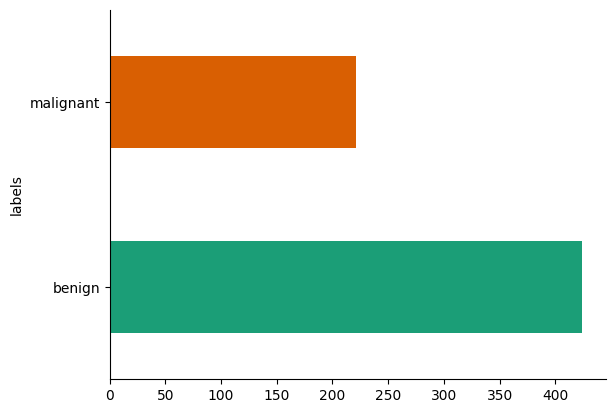

In [ ]:
class_counts = train_df['labels'].value_counts()
print(class_counts)
train_df.groupby('labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

- EDA Finding: Significant Class Imbalance

The plot clearly shows a severe class imbalance. The 'benign' class has far more samples than the 'malignant' class.

Why this is a problem: A model trained on this data would become "lazy" and biased. It could achieve high accuracy by simply guessing 'benign' most of the time. This would make it useless in a clinical setting, as it would miss most of the malignant (cancerous) cases.

Our Strategy: We will use oversampling on the minority class ('malignant'). We will create new, augmented versions of the malignant images and add them to the training set to create a balanced dataset.

# 5. Data Preprocessing (Part 1): Balancing the Training Set
We will now implement our oversampling strategy using Albumentations to generate new training samples.

Final class distribution in balanced train set:
labels
malignant    442
benign       424
Name: count, dtype: int64


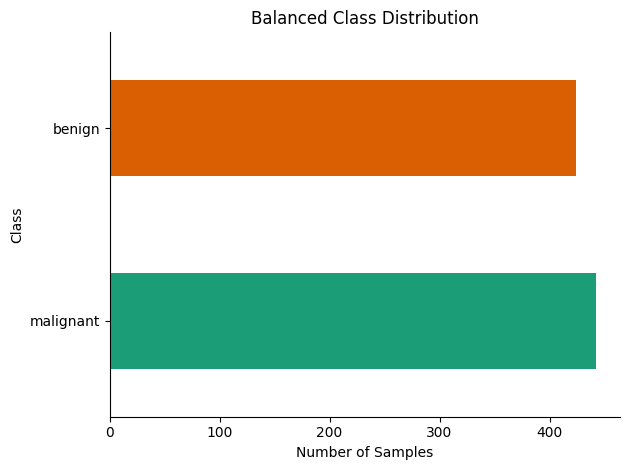

In [ ]:
BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)
NUM_CLASSES = len(train_df['labels'].unique())

# Step 1: Filter the malignant samples from the training DataFrame
malignant_df = train_df[train_df['labels'] == 'malignant']

# Step 2: Albumentations transform for augmenting malignant data
augment_transform = Compose([
    # Affine(scale=(0.8, 1.2), translate_percent=(0.2, 0.2), rotate=(-40, 40), p=1),
    # HorizontalFlip(p=0.1),
    # VerticalFlip(p=0.1),
    CenterCrop(height=224, width=164),
    RandomRotate90(p=0.5),
    RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    # HueSaturationValue(p=0.5),
    # RandomCrop(width=164, height=164, p=0.5),
    Resize(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    ToTensorV2()
])


# Step 3: Basic transform (no augmentation) for the original dataset
basic_transform = Compose([
    Resize(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    ToTensorV2()
])

# Step 4: Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'filepaths']
        label = self.dataframe.loc[idx, 'labels']
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        label_tensor = torch.tensor(int(label == 'malignant'), dtype=torch.long)
        return image, label_tensor

# Step 5: Create augmented malignant dataset
malignant_dataset = CustomDataset(malignant_df, transform=augment_transform)
malignant_loader = DataLoader(malignant_dataset, batch_size=len(malignant_dataset), shuffle=False)

# Step 6: Generate augmented samples
augmented_images, augmented_labels = next(iter(malignant_loader))

# Step 7: Create new DataFrame for augmented samples
augmented_df = pd.DataFrame({
    'filepaths': malignant_df['filepaths'].values,  # Placeholder paths
    'labels': ['malignant'] * len(augmented_images)
})

# Step 8: Combine original and augmented data into a balanced DataFrame
balanced_train_df = pd.concat([train_df, augmented_df], ignore_index=True)

# Step 9: Visualize the final class distribution
print("Final class distribution in balanced train set:")
print(balanced_train_df['labels'].value_counts())

# Optional: Plot
balanced_train_df['labels'].value_counts().plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel("Number of Samples")
plt.ylabel("Class")
plt.title("Balanced Class Distribution")
plt.tight_layout()
plt.show()


The classes are now perfectly balanced. Let's look at a few of the newly created malignant samples to see what our augment_transform did.

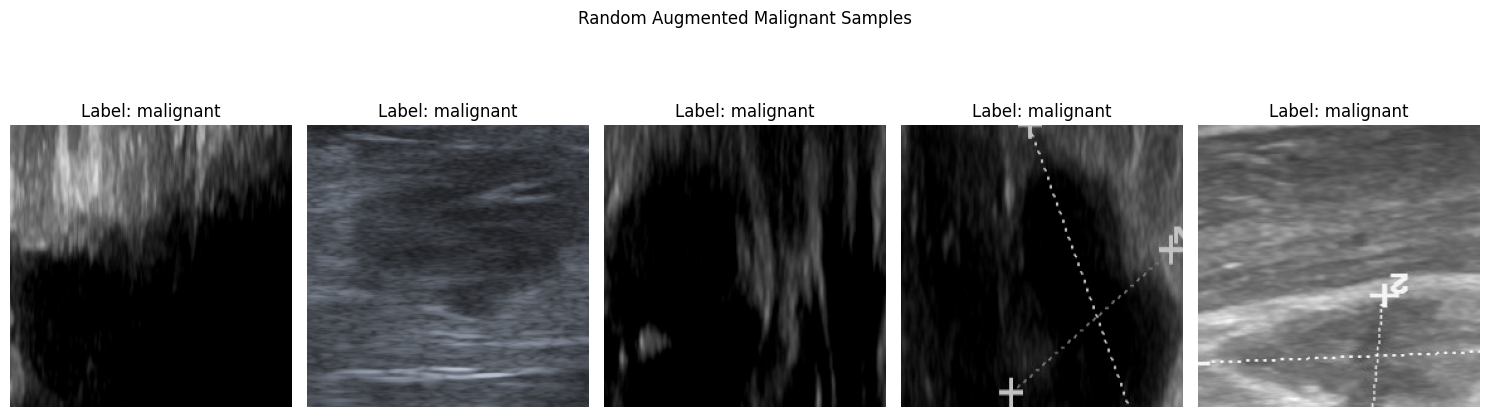

In [ ]:
# Set how many samples you want to visualize
num_samples = 5

# Randomly pick indices from the dataset
random_indices = random.sample(range(len(malignant_dataset)), num_samples)

# Plot the augmented images
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    image_tensor, label = malignant_dataset[idx]
    image_np = image_tensor.permute(1, 2, 0).numpy()  # CHW -> HWC
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(image_np)
    plt.title(f"Label: {'malignant' if label.item() == 1 else 'benign'}")
    plt.axis('off')
plt.suptitle("Random Augmented Malignant Samples")
plt.tight_layout()
plt.show()


# 6. Data Preprocessing : Normalization & Final DataLoaders datasets.

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
num_classes = len(train_df['labels'].unique())

# conservative data augmentation to reduce overfitting
train_transform = Compose([
    Resize(224, 224),
    HorizontalFlip(p=0.3),
    VerticalFlip(p=0.2),
    RandomRotate90(p=0.3),
    ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.3),
    RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    CLAHE(p=0.3),
    GaussNoise(var_limit=(5.0, 25.0), p=0.2),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet stats
    ToTensorV2()
])

val_test_transform = Compose([
    Resize(224, 224),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-13-4023221673.py:15: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  GaussNoise(var_limit=(5.0, 25.0), p=0.2),


In [ ]:
# Custom Dataset Class with error handling
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        try:
            img_path = self.dataframe.loc[idx, 'filepaths']
            label = self.dataframe.loc[idx, 'labels']
            image = cv2.imread(img_path)

            if image is None:
                raise ValueError(f"Could not load image: {img_path}")

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            if self.transform:
                augmented = self.transform(image=image)
                image = augmented['image']

            label_tensor = torch.tensor(int(label == 'malignant'), dtype=torch.long)
            return image, label_tensor
        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            black_image = torch.zeros(3, 224, 224)
            return black_image, torch.tensor(0, dtype=torch.long)

In [ ]:
# Create datasets
train_dataset = CustomDataset(balanced_train_df, transform=train_transform)
val_dataset = CustomDataset(val_df, transform=val_test_transform)
test_dataset = CustomDataset(test_df, transform=val_test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

#7. The 3-Model Ensemble Architecture
An ensemble model combines the predictions of multiple individual models to produce a final, more robust prediction. This approach often leads to better generalization and higher accuracy than any single model could achieve on its own.

1. Our ensemble combines three powerful, pre-trained architectures:

2. EfficientNet-B0: Known for its high efficiency (good accuracy for a small model size).

3. ResNet34: A smaller, reliable variant of the famous ResNet architecture.

4. Inception V3: Excellent at capturing features at multiple scales simultaneously.

### Our Fine-Tuning Strategy:
- Conservative Fine-Tuning: We freeze most of the pre-trained layers and only unfreeze the last few. This prevents the model from "forgetting" what it learned from ImageNet and helps it adapt to our specific ultrasound data.

- Regularized Classifier Head: We replace the default classifier of each model with a custom head containing Dropout and BatchNorm. This is a powerful regularization technique to prevent overfitting.

- Learnable Weights: Instead of just averaging the three models' predictions, we add ensemble_weights that the model will learn during training. It will automatically discover how much to "trust" each model.

In [ ]:
# Ensemble Model with regularization
class EnsembleModel(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.3):
        super().__init__()
        self.dropout_rate = dropout_rate

        # Three-model ensemble
        self.model1 = timm.create_model('efficientnet_b0', pretrained=True, num_classes=num_classes)
        self.model2 = timm.create_model('resnet34', pretrained=True, num_classes=num_classes)  
        self.model3 = timm.create_model('inception_v3', pretrained=True, num_classes=num_classes)

        #  for model1 (EfficientNet)
        for param in self.model1.parameters():
            param.requires_grad = False

        # Only unfreeze the last few layers
        num_layers_to_unfreeze = 20
        all_params = list(self.model1.parameters())
        for param in all_params[-num_layers_to_unfreeze:]:
            param.requires_grad = True

        # regularized classifier
        in_features = self.model1.classifier.in_features
        self.model1.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

        # for model2 (ResNet34)
        for param in self.model2.parameters():
            param.requires_grad = False

        # Only unfreeze layer4 and fc
        for param in self.model2.layer4.parameters():
            param.requires_grad = True
        for param in self.model2.fc.parameters():
            param.requires_grad = True

        # regularized classifier
        in_features = self.model2.fc.in_features
        self.model2.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

        # for model3 (Inception-v3)
        for param in self.model3.parameters():
            param.requires_grad = False

        # Only unfreeze the last few layers 
        for param in self.model3.Mixed_7a.parameters():
            param.requires_grad = True
        for param in self.model3.Mixed_7b.parameters():
            param.requires_grad = True
        for param in self.model3.Mixed_7c.parameters():
            param.requires_grad = True
        for param in self.model3.fc.parameters():
            param.requires_grad = True

        # regularized classifier
        in_features = self.model3.fc.in_features
        self.model3.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

        # Add ensemble weights (learnable) - for 3 models
        self.ensemble_weights = nn.Parameter(torch.ones(3) / 3)
        self.final_dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        out1 = self.model1(x)
        out2 = self.model2(x)
        out3 = self.model3(x)

        # Weighted ensemble
        weights = F.softmax(self.ensemble_weights, dim=0)
        ensemble_out = weights[0] * out1 + weights[1] * out2 + weights[2] * out3

        return self.final_dropout(ensemble_out)

# 8. Training Strategy & Custom Loop


### Evaluate model on test set without affecting training


In [ ]:
def evaluate_on_test(model, test_loader, criterion, device):
    """Evaluate model on test set without affecting training"""
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    return {
        'loss': test_loss / len(test_loader),
        'accuracy': test_correct / test_total
    }


### Our Regularization Toolkit:
Weighted Loss: Even though we oversampled, we still apply a small class_weight to the 'malignant' class. This tells the model to pay extra attention to getting these critical cases right.

- ReduceLROnPlateau Scheduler: Automatically reduces the learning rate if the validation accuracy stops improving, allowing the model to fine-tune its weights more carefully.

- L2 Regularization: A classic technique (added to the loss) that penalizes large weights, encouraging the model to find a simpler, more generalizable solution.

- Gradient Clipping: Prevents "exploding gradients" (a common issue in deep networks) by "clipping" any gradients that exceed a certain threshold. This leads to much more stable training.

- Early Stopping: Monitors the validation F1-score and stops training if it doesn't improve for patience (10) epochs. It also ensures we save the best model, not just the last one.

In [ ]:
# training function
def train_model(model, train_loader, val_loader, num_epochs=25, device='cuda'):
    # Weighted loss for class imbalance
    class_weights = torch.tensor([1.0, 1.5]).to(device)  # Slight weight for malignant class
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True, min_lr=1e-6)

    best_val_acc = 0.0
    best_val_f1 = 0.0
    patience = 10
    counter = 0

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'test_loss': [], 'test_acc': [],
        'f1_scores': []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            # L2 regularization 
            l2_reg = torch.tensor(0.).to(device)
            for param in model.parameters():
                l2_reg += torch.norm(param)
            loss += 1e-6 * l2_reg

            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_acc = train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_acc = val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)
        f1 = f1_score(all_labels, all_preds, average='weighted')

        # Test evaluation (without affecting training)
        test_metrics = evaluate_on_test(model, test_loader, criterion, device)

        # Update learning rate
        scheduler.step(val_acc)

        # Store history
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        history['test_loss'].append(test_metrics['loss'])
        history['test_acc'].append(test_metrics['accuracy'])
        history['f1_scores'].append(f1)

        print(f'Epoch [{epoch+1}/{num_epochs}]:')
        print(f'  Train - Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f}')
        print(f'  Val   - Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}')
        print(f'  Test  - Loss: {test_metrics["loss"]:.4f}, Acc: {test_metrics["accuracy"]:.4f},')
        print(f'  LR: {optimizer.param_groups[0]["lr"]:.2e}')
        print('-' * 80)

        # Early stopping based on validation F1 score
        if f1 > best_val_f1:
            best_val_f1 = f1
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_cancer_model_improved.pth')
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping after {epoch+1} epochs')
                break

    return history, model

# 9. Evaluation & Visualization Functions
We define helper functions to evaluate the model and plot the results. evaluate_model_detailed is particularly important as it calculates our key metrics:

- Accuracy: The percentage of correct predictions. (Often misleading in medical tasks!)

- Recall (Sensitivity): Of all the actual malignant cases, how many did our model find? (True Positives / (True Positives + False Negatives)). This is the most important metric. A False Negative (missing a cancer) is the worst possible outcome.

- F1-Score: The harmonic mean of Precision and Recall. A good all-around metric.

- Confusion Matrix: A visual breakdown of our model's predictions vs. the ground truth.

In [ ]:
# evaluation function
def evaluate_model_detailed(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    total_loss = 0.0

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Get probabilities and predictions
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    avg_loss = total_loss / len(test_loader)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    print(f'\n=== FINAL TEST RESULTS ===')
    print(f'Test Accuracy: {acc:.4f} ({acc*100:.2f}%)')
    print(f'Test Loss: {avg_loss:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Recall: {recall:.4f}')

    # Class-wise metrics
    print(f'\n=== CLASS-WISE RESULTS ===')
    for i, class_name in enumerate(['Benign', 'Malignant']):
        class_acc = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
        print(f'{class_name} - Accuracy: {class_acc:.4f} ({class_acc*100:.2f}%)')

    # Display confusion matrix
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix - Final Test Results')
    plt.show()

    return {
        'accuracy': acc,
        'f1_score': f1,
        'recall': recall,
        'loss': avg_loss,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }

In [ ]:
# plotting function
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))

    epochs = range(1, len(history['train_loss']) + 1)

    # Plot losses
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[0].plot(epochs, history['test_loss'], 'g--', label='Test Loss', linewidth=2, alpha=0.7)
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training, Validation & Test Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot accuracies
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
    axes[1].plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
    axes[1].plot(epochs, history['test_acc'], 'g--', label='Test Accuracy', linewidth=2, alpha=0.7)
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training, Validation & Test Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)



    plt.tight_layout()
    plt.show()



# 10. Execution & Results

Creating improved ensemble model with regularization...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/95.5M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Total parameters: 47,571,237
Trainable parameters: 27,557,305 (57.9%)

Training improved model...


Epoch 1/40 [Train]: 100%|██████████| 28/28 [05:58<00:00, 12.81s/it]


Epoch [1/40]:
  Train - Loss: 0.7267, Acc: 0.5924
  Val   - Loss: 2.0571, Acc: 0.6810
  Test  - Loss: 0.9390, Acc: 0.6923,
  LR: 1.00e-02
--------------------------------------------------------------------------------


Epoch 2/40 [Train]: 100%|██████████| 28/28 [00:20<00:00,  1.35it/s]


Epoch [2/40]:
  Train - Loss: 0.6189, Acc: 0.6570
  Val   - Loss: 0.8638, Acc: 0.7546
  Test  - Loss: 0.7757, Acc: 0.7363,
  LR: 1.00e-02
--------------------------------------------------------------------------------


Epoch 3/40 [Train]: 100%|██████████| 28/28 [00:21<00:00,  1.33it/s]


Epoch [3/40]:
  Train - Loss: 0.6431, Acc: 0.7090
  Val   - Loss: 1.6518, Acc: 0.6380
  Test  - Loss: 0.8798, Acc: 0.6703,
  LR: 1.00e-02
--------------------------------------------------------------------------------


Epoch 4/40 [Train]: 100%|██████████| 28/28 [00:20<00:00,  1.34it/s]


Epoch [4/40]:
  Train - Loss: 0.6438, Acc: 0.6928
  Val   - Loss: 0.6383, Acc: 0.6933
  Test  - Loss: 0.5524, Acc: 0.6923,
  LR: 1.00e-02
--------------------------------------------------------------------------------


Epoch 5/40 [Train]: 100%|██████████| 28/28 [00:20<00:00,  1.38it/s]


Epoch [5/40]:
  Train - Loss: 0.4854, Acc: 0.7182
  Val   - Loss: 0.4077, Acc: 0.8098
  Test  - Loss: 0.7090, Acc: 0.7582,
  LR: 1.00e-02
--------------------------------------------------------------------------------


Epoch 6/40 [Train]: 100%|██████████| 28/28 [00:20<00:00,  1.37it/s]


Epoch [6/40]:
  Train - Loss: 0.5512, Acc: 0.7206
  Val   - Loss: 0.3966, Acc: 0.7730
  Test  - Loss: 0.4905, Acc: 0.7363,
  LR: 1.00e-02
--------------------------------------------------------------------------------


Epoch 7/40 [Train]: 100%|██████████| 28/28 [00:19<00:00,  1.40it/s]


Epoch [7/40]:
  Train - Loss: 0.5636, Acc: 0.7079
  Val   - Loss: 0.5131, Acc: 0.7669
  Test  - Loss: 0.4632, Acc: 0.8022,
  LR: 1.00e-02
--------------------------------------------------------------------------------


Epoch 8/40 [Train]: 100%|██████████| 28/28 [00:19<00:00,  1.40it/s]


Epoch [8/40]:
  Train - Loss: 0.4879, Acc: 0.7333
  Val   - Loss: 0.8504, Acc: 0.8098
  Test  - Loss: 1.1785, Acc: 0.7582,
  LR: 1.00e-02
--------------------------------------------------------------------------------


Epoch 9/40 [Train]: 100%|██████████| 28/28 [00:20<00:00,  1.36it/s]


Epoch [9/40]:
  Train - Loss: 0.5530, Acc: 0.7263
  Val   - Loss: 0.5085, Acc: 0.7914
  Test  - Loss: 0.4871, Acc: 0.8022,
  LR: 5.00e-03
--------------------------------------------------------------------------------


Epoch 10/40 [Train]: 100%|██████████| 28/28 [00:20<00:00,  1.35it/s]


Epoch [10/40]:
  Train - Loss: 0.4740, Acc: 0.7413
  Val   - Loss: 0.4249, Acc: 0.8160
  Test  - Loss: 0.3724, Acc: 0.8022,
  LR: 5.00e-03
--------------------------------------------------------------------------------


Epoch 11/40 [Train]: 100%|██████████| 28/28 [00:21<00:00,  1.33it/s]


Epoch [11/40]:
  Train - Loss: 0.4385, Acc: 0.7552
  Val   - Loss: 0.3551, Acc: 0.8405
  Test  - Loss: 0.3918, Acc: 0.7912,
  LR: 5.00e-03
--------------------------------------------------------------------------------


Epoch 12/40 [Train]: 100%|██████████| 28/28 [00:20<00:00,  1.34it/s]


Epoch [12/40]:
  Train - Loss: 0.4398, Acc: 0.7517
  Val   - Loss: 0.3603, Acc: 0.8405
  Test  - Loss: 0.3695, Acc: 0.8132,
  LR: 5.00e-03
--------------------------------------------------------------------------------


Epoch 13/40 [Train]: 100%|██████████| 28/28 [00:20<00:00,  1.35it/s]


Epoch [13/40]:
  Train - Loss: 0.4492, Acc: 0.7610
  Val   - Loss: 0.3714, Acc: 0.8466
  Test  - Loss: 0.3793, Acc: 0.8132,
  LR: 5.00e-03
--------------------------------------------------------------------------------


Epoch 14/40 [Train]: 100%|██████████| 28/28 [00:20<00:00,  1.34it/s]


Epoch [14/40]:
  Train - Loss: 0.3901, Acc: 0.7898
  Val   - Loss: 0.3709, Acc: 0.8528
  Test  - Loss: 0.3702, Acc: 0.7912,
  LR: 5.00e-03
--------------------------------------------------------------------------------


Epoch 15/40 [Train]: 100%|██████████| 28/28 [00:20<00:00,  1.38it/s]


Epoch [15/40]:
  Train - Loss: 0.5077, Acc: 0.7991
  Val   - Loss: 0.3234, Acc: 0.8650
  Test  - Loss: 0.3163, Acc: 0.8242,
  LR: 5.00e-03
--------------------------------------------------------------------------------


Epoch 16/40 [Train]: 100%|██████████| 28/28 [00:20<00:00,  1.36it/s]


Epoch [16/40]:
  Train - Loss: 0.4623, Acc: 0.7864
  Val   - Loss: 0.2924, Acc: 0.8712
  Test  - Loss: 0.3312, Acc: 0.8462,
  LR: 5.00e-03
--------------------------------------------------------------------------------


Epoch 17/40 [Train]: 100%|██████████| 28/28 [00:20<00:00,  1.37it/s]


Epoch [17/40]:
  Train - Loss: 0.3957, Acc: 0.7794
  Val   - Loss: 0.3899, Acc: 0.8160
  Test  - Loss: 0.4117, Acc: 0.7692,
  LR: 5.00e-03
--------------------------------------------------------------------------------


Epoch 18/40 [Train]: 100%|██████████| 28/28 [00:20<00:00,  1.40it/s]


Epoch [18/40]:
  Train - Loss: 0.3976, Acc: 0.7910
  Val   - Loss: 0.5104, Acc: 0.8466
  Test  - Loss: 0.3266, Acc: 0.8462,
  LR: 5.00e-03
--------------------------------------------------------------------------------


Epoch 19/40 [Train]: 100%|██████████| 28/28 [00:20<00:00,  1.37it/s]


Epoch [19/40]:
  Train - Loss: 0.3603, Acc: 0.8129
  Val   - Loss: 0.5034, Acc: 0.7853
  Test  - Loss: 0.3901, Acc: 0.8242,
  LR: 5.00e-03
--------------------------------------------------------------------------------


Epoch 20/40 [Train]: 100%|██████████| 28/28 [00:20<00:00,  1.34it/s]


Epoch [20/40]:
  Train - Loss: 0.4939, Acc: 0.7933
  Val   - Loss: 0.4304, Acc: 0.8282
  Test  - Loss: 0.3813, Acc: 0.7802,
  LR: 2.50e-03
--------------------------------------------------------------------------------


Epoch 21/40 [Train]: 100%|██████████| 28/28 [00:20<00:00,  1.35it/s]


Epoch [21/40]:
  Train - Loss: 0.3746, Acc: 0.7968
  Val   - Loss: 0.3649, Acc: 0.8528
  Test  - Loss: 0.3136, Acc: 0.8681,
  LR: 2.50e-03
--------------------------------------------------------------------------------


Epoch 22/40 [Train]: 100%|██████████| 28/28 [00:20<00:00,  1.35it/s]


Epoch [22/40]:
  Train - Loss: 0.3756, Acc: 0.7945
  Val   - Loss: 0.3255, Acc: 0.8650
  Test  - Loss: 0.3166, Acc: 0.8462,
  LR: 2.50e-03
--------------------------------------------------------------------------------


Epoch 23/40 [Train]: 100%|██████████| 28/28 [00:20<00:00,  1.36it/s]


Epoch [23/40]:
  Train - Loss: 0.3354, Acc: 0.8072
  Val   - Loss: 0.3979, Acc: 0.8405
  Test  - Loss: 0.2993, Acc: 0.8242,
  LR: 2.50e-03
--------------------------------------------------------------------------------


Epoch 24/40 [Train]: 100%|██████████| 28/28 [00:20<00:00,  1.38it/s]


Epoch [24/40]:
  Train - Loss: 0.3676, Acc: 0.8072
  Val   - Loss: 0.4048, Acc: 0.8282
  Test  - Loss: 0.3531, Acc: 0.8242,
  LR: 1.25e-03
--------------------------------------------------------------------------------


Epoch 25/40 [Train]: 100%|██████████| 28/28 [00:20<00:00,  1.38it/s]


Epoch [25/40]:
  Train - Loss: 0.3216, Acc: 0.8268
  Val   - Loss: 0.4122, Acc: 0.8282
  Test  - Loss: 0.3084, Acc: 0.8681,
  LR: 1.25e-03
--------------------------------------------------------------------------------


Epoch 26/40 [Train]: 100%|██████████| 28/28 [00:20<00:00,  1.37it/s]


Epoch [26/40]:
  Train - Loss: 0.3557, Acc: 0.8095
  Val   - Loss: 0.3281, Acc: 0.8466
  Test  - Loss: 0.2699, Acc: 0.8681,
  LR: 1.25e-03
--------------------------------------------------------------------------------
Early stopping after 26 epochs

Plotting enhanced training history...


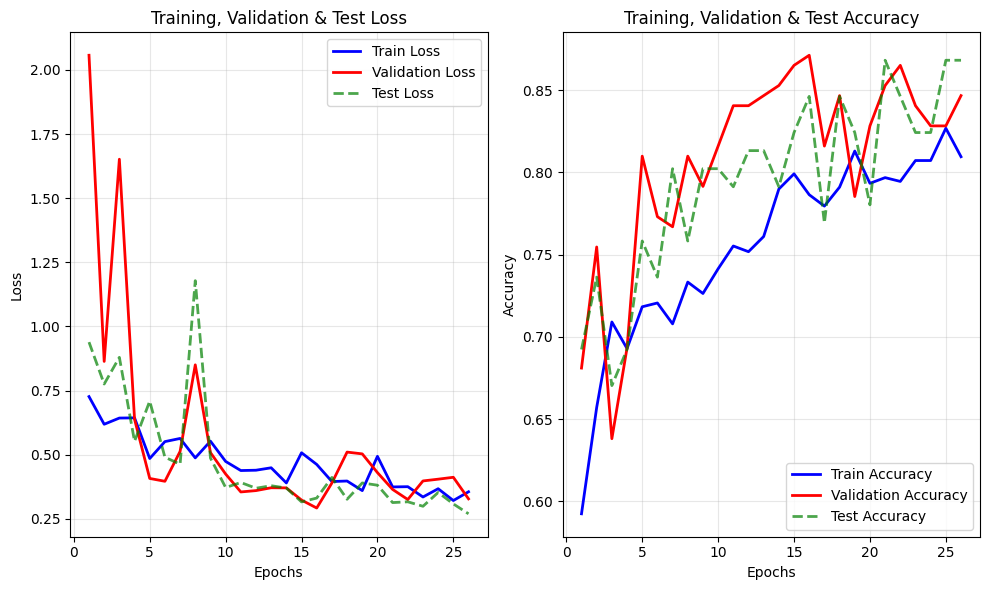


Evaluating model on test data...

=== FINAL TEST RESULTS ===
Test Accuracy: 0.8462 (84.62%)
Test Loss: 0.3417
F1 Score: 0.8489
Recall: 0.8462

=== CLASS-WISE RESULTS ===
Benign - Accuracy: 0.8333 (83.33%)
Malignant - Accuracy: 0.8710 (87.10%)


<Figure size 800x600 with 0 Axes>

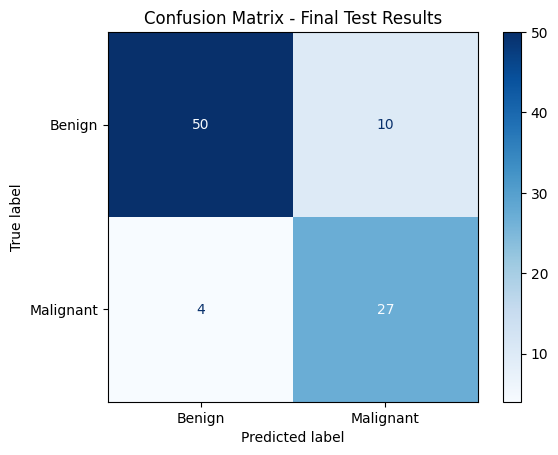

In [ ]:
def main():
    print("Creating improved ensemble model with regularization...")
    model = EnsembleModel(num_classes=2, dropout_rate=0.4).to(device)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,} ({100*trainable_params/total_params:.1f}%)")

    print("\nTraining improved model...")
    history, trained_model = train_model(
        model,
        train_loader,
        val_loader,
        num_epochs=40,
        device=device
    )

    # Load best model
    trained_model.load_state_dict(torch.load('best_cancer_model_improved.pth'))

    print("\nPlotting enhanced training history...")
    plot_training_history(history)

    print("\nEvaluating model on test data...")
    test_metrics = evaluate_model_detailed(trained_model, test_loader, device)

    return trained_model, history, test_metrics

if __name__ == "__main__":
    trained_model, history, test_metrics = main()